In [2]:
!conda activate control
import torch
print(torch.cuda.is_available())

True


In [4]:
import json
import cv2
import numpy as np
import h5py

from torch.utils.data import Dataset


class MyDataset(Dataset):
    def __init__(self):
        self.data = []
        with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
            images = f['images'][:]
            labels = f['labels'][:]
            for i in range(len(images)):
                newimg=np.transpose(images[i], (2, 1, 0))
                newlabel=np.transpose(labels[i], (1, 0))
                new_width = newimg.shape[1] // 2
                new_height = newimg.shape[0] // 2  
                # Adjust the thresholds based on your requirements
                low_threshold = 50
                high_threshold = 150
                # Apply Canny edge detection
                newlabel_uint8 = newimg.astype(np.uint8)
                edges = cv2.Canny(newlabel_uint8, low_threshold, high_threshold)
                self.data.append({
                    'image': cv2.resize(newimg, (256,256)),
                    'label': cv2.resize(edges, (256, 256)) ,
                    'prompt': 'An indoors design'
                })
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        source = item['label']
        target = item['image']
        prompt = item['prompt']

        # source = cv2.imread('./training/fill50k/' + source_filename)
        # target = cv2.imread('./training/fill50k/' + target_filename)

        # Do not forget that OpenCV read images in BGR order.
        source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
        target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

        # Normalize source images to [0, 1].
        source = source.astype(np.float32) / 255.0

        # Normalize target images to [-1, 1].
        target = (target.astype(np.float32) / 127.5) - 1.0

        return {'jpg': target, 'txt': prompt, 'hint': source}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1449
An indoors design
(256, 256, 3)
(256, 256, 3)


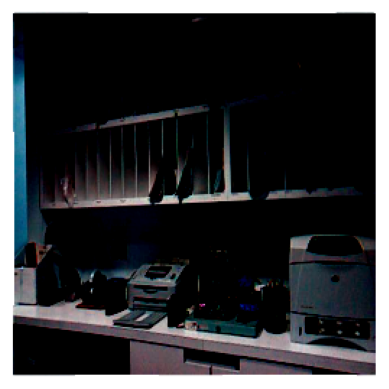

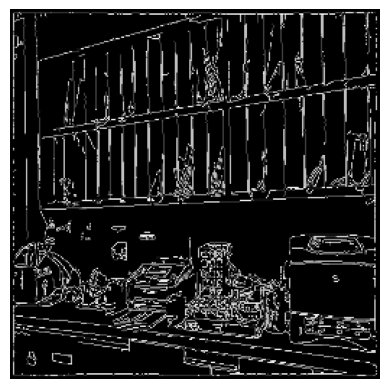

In [28]:
import matplotlib.pyplot as plt
dataset = MyDataset()
print(len(dataset))

item = dataset[10]
jpg = item['jpg']
txt = item['txt']
hint = item['hint']
print(txt)
print(jpg.shape)
print(hint.shape)

plt.imshow(jpg, cmap='gray' if jpg.ndim == 2 else None)
plt.axis('off')  # Turn off axis labels for a cleaner display
plt.show()

plt.imshow(hint, cmap='gray' if hint.ndim == 2 else None)
plt.axis('off')  # Turn off axis labels for a cleaner display
plt.show()

In [30]:
import pytorch_lightning as pl
import csv
from pytorch_lightning.callbacks import Callback

class LossLoggerCallback(Callback):
    def __init__(self):
        super().__init__()
        self.losses = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Log the loss at each training batch end
        loss = outputs['loss'].detach().cpu().item()  # Make sure to detach from the graph
        self.losses.append(loss)

    def on_train_end(self, trainer, pl_module):
        # Save the loss history to a CSV file at the end of training
        with open('./training_losses.csv', 'w') as f:
            writer = csv.writer(f)
            writer.writerow(['Step', 'Loss'])
            for i, loss in enumerate(self.losses):
                writer.writerow([i, loss])
        print("Training losses saved to './training_losses.csv'")


In [31]:
from share import *

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from cldm.logger import ImageLogger
from cldm.model import create_model, load_state_dict
from pytorch_lightning.callbacks import ModelCheckpoint


# Configs
resume_path = './models/control_sd15_canny.pth'
save_path = './models/updated_control_sd15_canny.pth'
batch_size = 4
logger_freq = 300
learning_rate = 1e-5
sd_locked = True
only_mid_control = False


# First use cpu to load models. Pytorch Lightning will automatically move it to GPUs.
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(resume_path, location='cpu'))
model.learning_rate = learning_rate
model.sd_locked = sd_locked
model.only_mid_control = only_mid_control
loss_logger_callback = LossLoggerCallback()

checkpoint_callback = ModelCheckpoint(
    dirpath='./models',            
    filename='updated_control_sd15_canny',
    save_top_k=1                               
)


# Misc
dataset = MyDataset()
dataloader = DataLoader(dataset, num_workers=0, batch_size=batch_size, shuffle=True)
logger = ImageLogger(batch_frequency=logger_freq)
trainer = pl.Trainer(gpus=1, precision=16, callbacks=[logger,checkpoint_callback,loss_logger_callback],max_epochs=30)


# Train!
trainer.fit(model, dataloader)

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_canny.pth]


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:280: LightningDeprecationWarning: Base `LightningModule.on_train_batch_start` hook signature has changed in v1.5. The `dataloader_idx` argument will be removed in v1.7.
  rank_zero_deprecation(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:287: LightningDeprecationWarning: Base `Callback.on_train_batch_end` hook signature has c

Epoch 0:   0%|          | 0/363 [00:00<?, ?it/s] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.21it/s]


Epoch 0:  83%|████████▎ | 300/363 [02:17<00:28,  2.18it/s, loss=0.132, v_num=2, train/loss_simple_step=0.099, train/loss_vlb_step=0.000361, train/loss_step=0.099, global_step=299.0]  Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


Epoch 1:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.196, v_num=2, train/loss_simple_step=0.881, train/loss_vlb_step=0.443, train/loss_step=0.881, global_step=362.0]               Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


Epoch 1:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.129, v_num=2, train/loss_simple_step=0.0273, train/loss_vlb_step=9.97e-5, train/loss_step=0.0273, global_step=662.0, train/loss_simple_epoch=0.139, train/loss_vlb_epoch=0.00244, train/loss_epoch=0.139]  Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Epoch 2:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.137, v_num=2, train/loss_simple_step=0.0858, train/loss_vlb_step=0.000284, train/loss_step=0.0858, global_step=725.0, train/loss_simple_epoch=0.139, train/loss_vlb_epoch=0.00244, train/loss_epoch=0.139]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 2:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.132, v_num=2, train/loss_simple_step=0.167, train/loss_vlb_step=0.00132, train/loss_step=0.167, global_step=1025.0, train/loss_simple_epoch=0.126, train/loss_vlb_epoch=0.00248, train/loss_epoch=0.126]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


Epoch 3:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.125, v_num=2, train/loss_simple_step=0.00905, train/loss_vlb_step=4.32e-5, train/loss_step=0.00905, global_step=1088.0, train/loss_simple_epoch=0.126, train/loss_vlb_epoch=0.00248, train/loss_epoch=0.126]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.19it/s]


Epoch 3:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.155, v_num=2, train/loss_simple_step=0.320, train/loss_vlb_step=0.00881, train/loss_step=0.320, global_step=1388.0, train/loss_simple_epoch=0.128, train/loss_vlb_epoch=0.00203, train/loss_epoch=0.128]    Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


Epoch 4:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.128, v_num=2, train/loss_simple_step=0.0222, train/loss_vlb_step=8.96e-5, train/loss_step=0.0222, global_step=1451.0, train/loss_simple_epoch=0.128, train/loss_vlb_epoch=0.00203, train/loss_epoch=0.128]            Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 4:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.105, v_num=2, train/loss_simple_step=0.146, train/loss_vlb_step=0.00103, train/loss_step=0.146, global_step=1751.0, train/loss_simple_epoch=0.128, train/loss_vlb_epoch=0.00282, train/loss_epoch=0.128]    Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 5:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.114, v_num=2, train/loss_simple_step=0.0921, train/loss_vlb_step=0.000303, train/loss_step=0.0921, global_step=1814.0, train/loss_simple_epoch=0.128, train/loss_vlb_epoch=0.00282, train/loss_epoch=0.128]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 5:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.137, v_num=2, train/loss_simple_step=0.102, train/loss_vlb_step=0.000536, train/loss_step=0.102, global_step=2114.0, train/loss_simple_epoch=0.132, train/loss_vlb_epoch=0.00299, train/loss_epoch=0.132]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 6:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.153, v_num=2, train/loss_simple_step=0.0494, train/loss_vlb_step=0.000167, train/loss_step=0.0494, global_step=2177.0, train/loss_simple_epoch=0.132, train/loss_vlb_epoch=0.00299, train/loss_epoch=0.132]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.12it/s]


Epoch 6:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.111, v_num=2, train/loss_simple_step=0.104, train/loss_vlb_step=0.000419, train/loss_step=0.104, global_step=2477.0, train/loss_simple_epoch=0.130, train/loss_vlb_epoch=0.00282, train/loss_epoch=0.130]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 7:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.0972, v_num=2, train/loss_simple_step=0.133, train/loss_vlb_step=0.000483, train/loss_step=0.133, global_step=2540.0, train/loss_simple_epoch=0.130, train/loss_vlb_epoch=0.00282, train/loss_epoch=0.130]           Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Epoch 7:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.127, v_num=2, train/loss_simple_step=0.305, train/loss_vlb_step=0.00719, train/loss_step=0.305, global_step=2840.0, train/loss_simple_epoch=0.124, train/loss_vlb_epoch=0.00202, train/loss_epoch=0.124]    Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 8:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.125, v_num=2, train/loss_simple_step=0.0167, train/loss_vlb_step=7.26e-5, train/loss_step=0.0167, global_step=2903.0, train/loss_simple_epoch=0.124, train/loss_vlb_epoch=0.00202, train/loss_epoch=0.124]            Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 8:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.119, v_num=2, train/loss_simple_step=0.0919, train/loss_vlb_step=0.000457, train/loss_step=0.0919, global_step=3203.0, train/loss_simple_epoch=0.134, train/loss_vlb_epoch=0.00313, train/loss_epoch=0.134] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Epoch 9:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.103, v_num=2, train/loss_simple_step=0.0532, train/loss_vlb_step=0.000179, train/loss_step=0.0532, global_step=3266.0, train/loss_simple_epoch=0.134, train/loss_vlb_epoch=0.00313, train/loss_epoch=0.134]           Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.12it/s]


Epoch 9:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.119, v_num=2, train/loss_simple_step=0.215, train/loss_vlb_step=0.0155, train/loss_step=0.215, global_step=3566.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00267, train/loss_epoch=0.119]     Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 10:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.127, v_num=2, train/loss_simple_step=0.0171, train/loss_vlb_step=7.31e-5, train/loss_step=0.0171, global_step=3629.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00267, train/loss_epoch=0.119]           Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Epoch 10:  83%|████████▎ | 300/363 [02:18<00:29,  2.17it/s, loss=0.137, v_num=2, train/loss_simple_step=0.139, train/loss_vlb_step=0.000607, train/loss_step=0.139, global_step=3929.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00265, train/loss_epoch=0.119]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.07it/s]


Epoch 11:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.116, v_num=2, train/loss_simple_step=0.00962, train/loss_vlb_step=4.49e-5, train/loss_step=0.00962, global_step=3992.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00265, train/loss_epoch=0.119]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Epoch 11:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.154, v_num=2, train/loss_simple_step=0.114, train/loss_vlb_step=0.000625, train/loss_step=0.114, global_step=4292.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00207, train/loss_epoch=0.119]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 12:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.13, v_num=2, train/loss_simple_step=0.178, train/loss_vlb_step=0.000663, train/loss_step=0.178, global_step=4355.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.00207, train/loss_epoch=0.119]              Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 12:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.128, v_num=2, train/loss_simple_step=0.119, train/loss_vlb_step=0.000494, train/loss_step=0.119, global_step=4655.0, train/loss_simple_epoch=0.131, train/loss_vlb_epoch=0.00274, train/loss_epoch=0.131]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 13:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.138, v_num=2, train/loss_simple_step=0.0959, train/loss_vlb_step=0.000317, train/loss_step=0.0959, global_step=4718.0, train/loss_simple_epoch=0.131, train/loss_vlb_epoch=0.00274, train/loss_epoch=0.131]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.05it/s]


Epoch 13:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.115, v_num=2, train/loss_simple_step=0.150, train/loss_vlb_step=0.000581, train/loss_step=0.150, global_step=5018.0, train/loss_simple_epoch=0.126, train/loss_vlb_epoch=0.00207, train/loss_epoch=0.126]    Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 14:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.111, v_num=2, train/loss_simple_step=0.0199, train/loss_vlb_step=7.85e-5, train/loss_step=0.0199, global_step=5081.0, train/loss_simple_epoch=0.126, train/loss_vlb_epoch=0.00207, train/loss_epoch=0.126]            Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.98it/s]


Epoch 14:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.0939, v_num=2, train/loss_simple_step=0.0335, train/loss_vlb_step=0.00012, train/loss_step=0.0335, global_step=5381.0, train/loss_simple_epoch=0.117, train/loss_vlb_epoch=0.00226, train/loss_epoch=0.117] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.02it/s]


Epoch 15:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.131, v_num=2, train/loss_simple_step=0.00266, train/loss_vlb_step=1.51e-5, train/loss_step=0.00266, global_step=5444.0, train/loss_simple_epoch=0.117, train/loss_vlb_epoch=0.00226, train/loss_epoch=0.117]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 15:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.0997, v_num=2, train/loss_simple_step=0.272, train/loss_vlb_step=0.00159, train/loss_step=0.272, global_step=5744.0, train/loss_simple_epoch=0.125, train/loss_vlb_epoch=0.00329, train/loss_epoch=0.125]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Epoch 16:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.161, v_num=2, train/loss_simple_step=0.370, train/loss_vlb_step=0.00286, train/loss_step=0.370, global_step=5807.0, train/loss_simple_epoch=0.125, train/loss_vlb_epoch=0.00329, train/loss_epoch=0.125]             Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 16:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.127, v_num=2, train/loss_simple_step=0.0858, train/loss_vlb_step=0.000296, train/loss_step=0.0858, global_step=6107.0, train/loss_simple_epoch=0.120, train/loss_vlb_epoch=0.00188, train/loss_epoch=0.120] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 17:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.137, v_num=2, train/loss_simple_step=0.0157, train/loss_vlb_step=6.98e-5, train/loss_step=0.0157, global_step=6170.0, train/loss_simple_epoch=0.120, train/loss_vlb_epoch=0.00188, train/loss_epoch=0.120]           Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.03it/s]


Epoch 17:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.133, v_num=2, train/loss_simple_step=0.0863, train/loss_vlb_step=0.000518, train/loss_step=0.0863, global_step=6470.0, train/loss_simple_epoch=0.125, train/loss_vlb_epoch=0.00276, train/loss_epoch=0.125] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Epoch 18:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.12, v_num=2, train/loss_simple_step=0.0147, train/loss_vlb_step=6.25e-5, train/loss_step=0.0147, global_step=6533.0, train/loss_simple_epoch=0.125, train/loss_vlb_epoch=0.00276, train/loss_epoch=0.125]            Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 18:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.141, v_num=2, train/loss_simple_step=0.263, train/loss_vlb_step=0.0545, train/loss_step=0.263, global_step=6833.0, train/loss_simple_epoch=0.121, train/loss_vlb_epoch=0.0021, train/loss_epoch=0.121]     Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 19:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.116, v_num=2, train/loss_simple_step=0.319, train/loss_vlb_step=0.0018, train/loss_step=0.319, global_step=6896.0, train/loss_simple_epoch=0.121, train/loss_vlb_epoch=0.0021, train/loss_epoch=0.121]               Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.15it/s]


Epoch 19:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.147, v_num=2, train/loss_simple_step=0.0549, train/loss_vlb_step=0.000184, train/loss_step=0.0549, global_step=7196.0, train/loss_simple_epoch=0.117, train/loss_vlb_epoch=0.0027, train/loss_epoch=0.117]  Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


Epoch 20:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.134, v_num=2, train/loss_simple_step=0.383, train/loss_vlb_step=0.00285, train/loss_step=0.383, global_step=7259.0, train/loss_simple_epoch=0.117, train/loss_vlb_epoch=0.0027, train/loss_epoch=0.117]              Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.14it/s]


Epoch 20:  83%|████████▎ | 300/363 [02:19<00:29,  2.16it/s, loss=0.135, v_num=2, train/loss_simple_step=0.0423, train/loss_vlb_step=0.000147, train/loss_step=0.0423, global_step=7559.0, train/loss_simple_epoch=0.117, train/loss_vlb_epoch=0.00246, train/loss_epoch=0.117] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 21:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.13, v_num=2, train/loss_simple_step=0.0638, train/loss_vlb_step=0.00021, train/loss_step=0.0638, global_step=7622.0, train/loss_simple_epoch=0.117, train/loss_vlb_epoch=0.00246, train/loss_epoch=0.117]             Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.08it/s]


Epoch 21:  83%|████████▎ | 300/363 [02:19<00:29,  2.16it/s, loss=0.128, v_num=2, train/loss_simple_step=0.137, train/loss_vlb_step=0.00211, train/loss_step=0.137, global_step=7922.0, train/loss_simple_epoch=0.121, train/loss_vlb_epoch=0.00242, train/loss_epoch=0.121]     Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 22:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.111, v_num=2, train/loss_simple_step=0.063, train/loss_vlb_step=0.000213, train/loss_step=0.063, global_step=7985.0, train/loss_simple_epoch=0.121, train/loss_vlb_epoch=0.00242, train/loss_epoch=0.121]             Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 22:  83%|████████▎ | 300/363 [02:19<00:29,  2.16it/s, loss=0.174, v_num=2, train/loss_simple_step=0.0962, train/loss_vlb_step=0.000699, train/loss_step=0.0962, global_step=8285.0, train/loss_simple_epoch=0.126, train/loss_vlb_epoch=0.0028, train/loss_epoch=0.126] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


Epoch 23:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.113, v_num=2, train/loss_simple_step=0.102, train/loss_vlb_step=0.000341, train/loss_step=0.102, global_step=8348.0, train/loss_simple_epoch=0.126, train/loss_vlb_epoch=0.0028, train/loss_epoch=0.126]            Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.20it/s]


Epoch 23:  83%|████████▎ | 300/363 [02:18<00:29,  2.16it/s, loss=0.122, v_num=2, train/loss_simple_step=0.0139, train/loss_vlb_step=5.6e-5, train/loss_step=0.0139, global_step=8648.0, train/loss_simple_epoch=0.124, train/loss_vlb_epoch=0.00273, train/loss_epoch=0.124]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 24:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.101, v_num=2, train/loss_simple_step=0.0253, train/loss_vlb_step=9.74e-5, train/loss_step=0.0253, global_step=8711.0, train/loss_simple_epoch=0.124, train/loss_vlb_epoch=0.00273, train/loss_epoch=0.124]            Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.99it/s]


Epoch 24:  83%|████████▎ | 300/363 [02:19<00:29,  2.16it/s, loss=0.13, v_num=2, train/loss_simple_step=0.136, train/loss_vlb_step=0.000546, train/loss_step=0.136, global_step=9011.0, train/loss_simple_epoch=0.116, train/loss_vlb_epoch=0.00217, train/loss_epoch=0.116]    Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.10it/s]


Epoch 25:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.0963, v_num=2, train/loss_simple_step=0.00193, train/loss_vlb_step=1.15e-5, train/loss_step=0.00193, global_step=9074.0, train/loss_simple_epoch=0.116, train/loss_vlb_epoch=0.00217, train/loss_epoch=0.116]          Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 25:  83%|████████▎ | 300/363 [02:19<00:29,  2.16it/s, loss=0.141, v_num=2, train/loss_simple_step=0.0776, train/loss_vlb_step=0.000391, train/loss_step=0.0776, global_step=9374.0, train/loss_simple_epoch=0.124, train/loss_vlb_epoch=0.00345, train/loss_epoch=0.124] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 26:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.123, v_num=2, train/loss_simple_step=0.258, train/loss_vlb_step=0.00114, train/loss_step=0.258, global_step=9437.0, train/loss_simple_epoch=0.124, train/loss_vlb_epoch=0.00345, train/loss_epoch=0.124]              Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.06it/s]


Epoch 26:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.117, v_num=2, train/loss_simple_step=0.105, train/loss_vlb_step=0.000417, train/loss_step=0.105, global_step=9737.0, train/loss_simple_epoch=0.116, train/loss_vlb_epoch=0.00311, train/loss_epoch=0.116]   Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.96it/s]


Epoch 27:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.101, v_num=2, train/loss_simple_step=0.0341, train/loss_vlb_step=0.000122, train/loss_step=0.0341, global_step=9800.0, train/loss_simple_epoch=0.116, train/loss_vlb_epoch=0.00311, train/loss_epoch=0.116]           Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


Epoch 27:  83%|████████▎ | 300/363 [02:19<00:29,  2.14it/s, loss=0.138, v_num=2, train/loss_simple_step=0.112, train/loss_vlb_step=0.000423, train/loss_step=0.112, global_step=10100.0, train/loss_simple_epoch=0.118, train/loss_vlb_epoch=0.00333, train/loss_epoch=0.118]  Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.13it/s]


Epoch 28:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.118, v_num=2, train/loss_simple_step=0.475, train/loss_vlb_step=0.00671, train/loss_step=0.475, global_step=10163.0, train/loss_simple_epoch=0.118, train/loss_vlb_epoch=0.00333, train/loss_epoch=0.118]             Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 28:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.123, v_num=2, train/loss_simple_step=0.187, train/loss_vlb_step=0.00126, train/loss_step=0.187, global_step=10463.0, train/loss_simple_epoch=0.123, train/loss_vlb_epoch=0.00371, train/loss_epoch=0.123]    Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.11it/s]


Epoch 29:   0%|          | 0/363 [00:00<?, ?it/s, loss=0.114, v_num=2, train/loss_simple_step=0.169, train/loss_vlb_step=0.000626, train/loss_step=0.169, global_step=10526.0, train/loss_simple_epoch=0.123, train/loss_vlb_epoch=0.00371, train/loss_epoch=0.123]             Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.00it/s]


Epoch 29:  83%|████████▎ | 300/363 [02:19<00:29,  2.15it/s, loss=0.0917, v_num=2, train/loss_simple_step=0.0448, train/loss_vlb_step=0.000154, train/loss_step=0.0448, global_step=10826.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.0027, train/loss_epoch=0.119] Data shape for DDIM sampling is (4, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps



DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


Epoch 29: 100%|██████████| 363/363 [03:13<00:00,  1.87it/s, loss=0.119, v_num=2, train/loss_simple_step=0.00344, train/loss_vlb_step=1.83e-5, train/loss_step=0.00344, global_step=10889.0, train/loss_simple_epoch=0.119, train/loss_vlb_epoch=0.0027, train/loss_epoch=0.119]


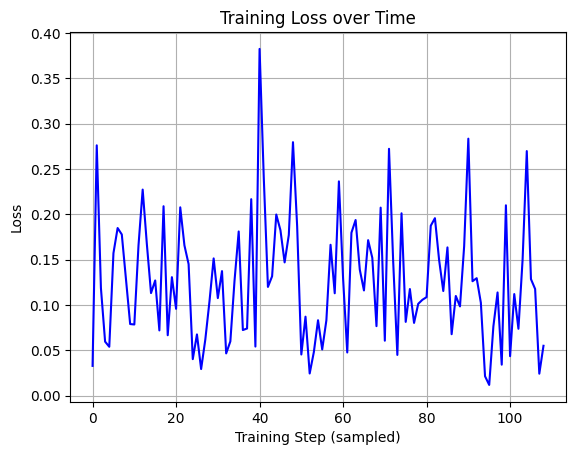

In [32]:
# Sample every 100th point for a cleaner plot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the loss data
loss_data = pd.read_csv('./training_losses.csv')

# Extract only the loss values as an array
ypoints = np.array(loss_data['Loss'])

sampled_ypoints = ypoints[::100]  # Adjust the number to control how many points to skip

plt.plot(sampled_ypoints, linestyle='-', marker='', color='b')  # No marker, just a line
plt.xlabel('Training Step (sampled)')
plt.ylabel('Loss')
plt.title('Training Loss over Time')
plt.grid(True)
plt.show()


In [34]:
from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.uniformer import UniformerDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

save_path = './models/saved_model.pth'
model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict(save_path, location='cuda'))
model=model.cuda()
ddim_sampler = DDIMSampler(model)
apply_uniformer = UniformerDetector()

ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/saved_model.pth]
Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /teamspace/studios/this_studio/ControlNet/annotator/ckpts/upernet_global_small.pth


In [35]:
import torch
import random
import einops
import numpy as np
import cv2
import config

def process(input_images, prompt, a_prompt, n_prompt, num_samples, image_resolution, detect_resolution, ddim_steps, guess_mode, strength, scale, seed, eta):
    results = []
    with torch.no_grad():
        for input_image in input_images:
            # Preprocess the input image
            input_image = HWC3(input_image)
            detected_map = apply_uniformer(resize_image(input_image, detect_resolution))
            img = resize_image(input_image, image_resolution)
            H, W, C = img.shape

            detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_NEAREST)

            # Prepare control tensor
            control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
            control = torch.stack([control for _ in range(num_samples)], dim=0)
            control = einops.rearrange(control, 'b h w c -> b c h w').clone()

            # Set the random seed if needed
            if seed == -1:
                seed = random.randint(0, 65535)
            seed_everything(seed)

            # Adjust memory settings if configured
            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            # Prepare conditioning and unconditioning
            cond = {
                "c_concat": [control], 
                "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]
            }
            un_cond = {
                "c_concat": None if guess_mode else [control], 
                "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]
            }
            shape = (4, H // 8, W // 8)

            if config.save_memory:
                model.low_vram_shift(is_diffusing=True)

            # Apply control scales
            model.control_scales = ([strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else [strength] * 13)

            # Run sampling
            samples, intermediates = ddim_sampler.sample(
                ddim_steps, num_samples, shape, cond, verbose=False, eta=eta,
                unconditional_guidance_scale=scale,
                unconditional_conditioning=un_cond
            )

            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            # Decode the generated samples
            x_samples = model.decode_first_stage(samples)
            x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)

            # Take the first generated result from the batch as the single output image
            results.append(x_samples[0])  # Only taking the first image in each batch

    # Return the processed results for each input image
    return results

In [37]:
import h5py
# Example usage:
input_images=[]
with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['images'][:]             
    for i in range(len(images)):
        newimg=np.transpose(images[i], (2,1, 0))
        new_width = newimg.shape[1] // 2
        new_height = newimg.shape[0] // 2  
        low_threshold = 50
        high_threshold = 150
        newlabel_uint8 = newimg.astype(np.uint8)
        edges = cv2.Canny(newlabel_uint8, low_threshold, high_threshold)
        resized_img=cv2.resize(edges, (256,256))
        if resized_img.dtype != np.uint8:
            resized_img = (resized_img * 255).astype(np.uint8) if resized_img.max() <= 1 else resized_img.astype(np.uint8)
        input_images.append(resized_img)
  
output_images = process(
    input_images[:100], 
    prompt="An indoors design", 
    a_prompt="additional prompt", 
    n_prompt="negative prompt",
    num_samples=1, 
    image_resolution=256, 
    detect_resolution=256, 
    ddim_steps=50, 
    guess_mode=False, 
    strength=1.0, 
    scale=7.5, 
    seed=42, 
    eta=0.0
)

import os
output_folder = 'output_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through the output images and save them
for idx, image in enumerate(output_images):
    # Define the file path to save the image
    image_path = os.path.join(output_folder, f"output_image_{idx + 1}.png")
    
    # Save the image using OpenCV (assuming the image is in uint8 format)
    cv2.imwrite(image_path, image)
    print(f"Image saved at: {image_path}")

# output_images will contain one processed image for each input image

/teamspace/studios/this_studio/ControlNet/annotator/uniformer/mmseg/models/segmentors/base.py:271: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.56it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.51it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.53it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.50it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.48it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.47it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.49it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.54it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.52it/s]
Global seed set to 42


Data shape for DDIM sampling is (1, 4, 32, 32), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|██████████| 50/50 [00:06<00:00,  7.55it/s]


Image saved at: output_images/output_image_1.png
Image saved at: output_images/output_image_2.png
Image saved at: output_images/output_image_3.png
Image saved at: output_images/output_image_4.png
Image saved at: output_images/output_image_5.png
Image saved at: output_images/output_image_6.png
Image saved at: output_images/output_image_7.png
Image saved at: output_images/output_image_8.png
Image saved at: output_images/output_image_9.png
Image saved at: output_images/output_image_10.png
Image saved at: output_images/output_image_11.png
Image saved at: output_images/output_image_12.png
Image saved at: output_images/output_image_13.png
Image saved at: output_images/output_image_14.png
Image saved at: output_images/output_image_15.png
Image saved at: output_images/output_image_16.png
Image saved at: output_images/output_image_17.png
Image saved at: output_images/output_image_18.png
Image saved at: output_images/output_image_19.png
Image saved at: output_images/output_image_20.png
Image sav

In [25]:
import os
output_folder = 'real_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['images'][:] 
    images=images[:100]
    for i in range(len(images)):
        newimg=np.transpose(images[i], (2, 1, 0))
        new_width = newimg.shape[1] // 2
        new_height = newimg.shape[0] // 2  
        resized_img=cv2.resize(newimg, (256,256))
        if resized_img.dtype != np.uint8:
            resized_img = (resized_img * 255).astype(np.uint8) if resized_img.max() <= 1 else resized_img.astype(np.uint8)
        image_path = os.path.join(output_folder, f"real_image_{i+ 1}.png")
        cv2.imwrite(image_path, resized_img)

In [33]:
import torch

# Load the checkpoint
checkpoint = torch.load("./models/updated_control_sd15_canny-v1.ckpt")

# Extract the state_dict
# Sometimes the checkpoint may include extra metadata, so you may need to adjust this depending on the structure.
# Common structures:
# 1. checkpoint['state_dict'] - if 'state_dict' is stored as a separate key.
# 2. checkpoint - if the checkpoint itself is the state_dict.

# Check for structure and assign accordingly
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
else:
    state_dict = checkpoint

# Save the model's state_dict as a .pth file
torch.save(state_dict, "./models/saved_model.pth")


In [2]:
from share import *
import config

import cv2
import einops
import gradio as gr
import numpy as np
import torch
import random

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

apply_canny = CannyDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./models/saved_model.pth', location='cpu'))
ddim_sampler = DDIMSampler(model)

logging improved.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/saved_model.pth]


In [13]:
def process(input_images, prompt, a_prompt, n_prompt, num_samples, image_resolution, ddim_steps, guess_mode, strength, scale, seed, eta, low_threshold, high_threshold):
    for input_image in input_images:
        with torch.no_grad():
            input_image = np.asarray(input_image, dtype=np.uint8)
            img = resize_image(HWC3(input_image), image_resolution)
            H, W, C = img.shape
    
            detected_map = apply_canny(img, low_threshold, high_threshold)
            detected_map = HWC3(detected_map)
    
            control = torch.from_numpy(detected_map.copy()).float().cuda() / 255.0
            control = torch.stack([control for _ in range(num_samples)], dim=0)
            control = einops.rearrange(control, 'b h w c -> b c h w').clone()
    
            if seed == -1:
                seed = random.randint(0, 65535)
            seed_everything(seed)
    
            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)

            cond = {"c_concat": [control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)]}
            un_cond = {"c_concat": None if guess_mode else [control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)]}
            shape = (4, H // 8, W // 8)
    
            if config.save_memory:
                model.low_vram_shift(is_diffusing=True)
    
            model.control_scales = [strength * (0.825 ** float(12 - i)) for i in range(13)] if guess_mode else ([strength] * 13)  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
            samples, intermediates = ddim_sampler.sample(ddim_steps, num_samples,
                                                         shape, cond, verbose=False, eta=eta,
                                                         unconditional_guidance_scale=scale,
                                                         unconditional_conditioning=un_cond)
    
            if config.save_memory:
                model.low_vram_shift(is_diffusing=False)
    
            x_samples = model.decode_first_stage(samples)
            x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    
            results = [x_samples[i] for i in range(num_samples)]
        return [255 - detected_map] + results

In [ ]:
import h5py
# Example usage:
input_images=[]
with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['images'][:]             
    for i in range(len(images)):
        newimg=np.transpose(images[i], (2,1, 0))
        new_width = newimg.shape[1] // 2
        new_height = newimg.shape[0] // 2  
        # low_threshold = 50
        # high_threshold = 150
        # newlabel_uint8 = newimg.astype(np.uint8)
        # edges = cv2.Canny(newlabel_uint8, low_threshold, high_threshold)
        resized_img=cv2.resize(newimg, (256,256))
        if resized_img.dtype != np.uint8:
            resized_img = (resized_img * 255).astype(np.uint8) if resized_img.max() <= 1 else resized_img.astype(np.uint8)
        input_images.append(resized_img)
  
output_images = process(
    input_images[:100], 
    prompt="An indoors design", 
    a_prompt="additional prompt", 
    n_prompt="negative prompt",
    num_samples=1, 
    image_resolution=256,  
    ddim_steps=50, 
    guess_mode=False, 
    strength=1.0, 
    scale=7.5, 
    seed=42, 
    eta=0.0,
    low_threshold=50,
    high_threshold=150
)

import os
output_folder = 'output_images2'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Loop through the output images and save them
for idx, image in enumerate(output_images):
    # Define the file path to save the image
    image_path = os.path.join(output_folder, f"output_image_{idx + 1}.png")
    
    # Save the image using OpenCV (assuming the image is in uint8 format)
    cv2.imwrite(image_path, image)
    print(f"Image saved at: {image_path}")

# output_images will contain one processed image for each input image